In [1]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.multioutput import MultiOutputClassifier
import warnings

# Import various classifiers.
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Set default settings.
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

# Split into training, testing, and validation datasets

In [2]:
# Read in preprocessed data on trees.
df = pd.read_csv('./data/data_preprocessed/features.csv.gz', compression='gzip')

# Split dataset into features and targets.
x = df.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df.loc[:, 'health_Dead|Stump':]

# Split features and targets further into training, testing, and validation datasets.
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                      y,
                                                      test_size=0.5,
                                                      random_state=34,
                                                      shuffle=True,
                                                      stratify=y)

x_training, x_testing, y_training, y_testing = train_test_split(x_train,
                                                                y_train,
                                                                test_size=0.5,
                                                                random_state=34,
                                                                shuffle=True,
                                                                stratify=y_train)

# Apply data sampling techniques (Oversampling)

In [3]:
# Bootstrap the minority classes of the targets, i.e. pick samples of the targets randomly with replacement for
# each target class that has less samples.
ros = RandomOverSampler(sampling_strategy='minority', random_state=34)

# Fit and transform the RandomOverSampler with the original training data sets.
x_training_ros, y_training_ros = ros.fit_resample(x_training.values, y_training.values)

Text(0.0, 0.58, 'Number of trees')

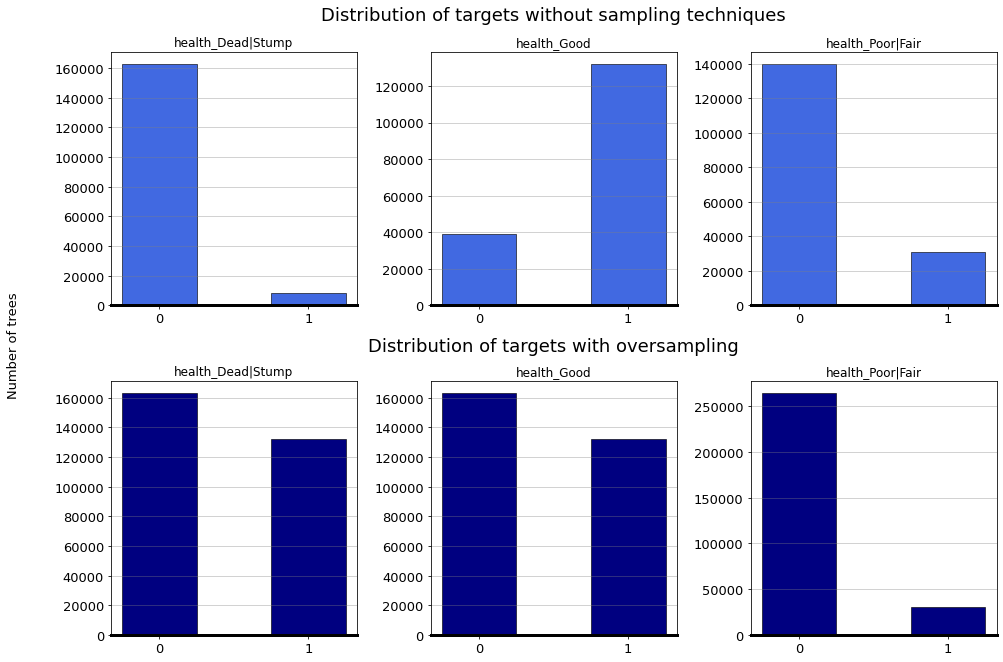

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
plt.subplots_adjust(bottom=0.05, left=0.09, right=0.91, top=0.95)

# Plot distribution of targets before applying any sampling technique.
y_training.hist(ax=axs[0],
                align='left',
                bins=np.arange(3),
                rwidth=0.5,
                grid=False,
                color='royalblue',
                edgecolor='k',
                linewidth=0.6)

for each in axs[0]:
    each.spines['bottom'].set_linewidth(3)
    each.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
    each.tick_params(axis='both', bottom='off', which='major', labelsize=13)
    each.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
    each.xaxis.set_minor_locator(ticker.FixedLocator([0, 1]))

# Plot distribution of targets after oversampling.
pd.DataFrame(y_training_ros, columns=df.columns[-3:]).hist(ax=axs[1],
                                                           align='left',
                                                           bins=np.arange(3),
                                                           rwidth=0.5,
                                                           grid=False,
                                                           color='navy',
                                                           edgecolor='k',
                                                           linewidth=0.6)

for each in axs[1]:
    each.spines['bottom'].set_linewidth(3)
    each.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
    each.tick_params(axis='both', which='major', labelsize=13)
    each.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
    each.xaxis.set_minor_locator(ticker.FixedLocator([0, 1]))

plt.figtext(0.5, 1.02, 'Distribution of targets without sampling techniques', fontsize=18, ha='center', va='top')
plt.figtext(0.5, 0.51, 'Distribution of targets with oversampling', fontsize=18, ha='center', va='top')
plt.figtext(0.0, 0.58, 'Number of trees', fontsize=13, ha='center', rotation=90, va='top')

# Modeling

In [5]:
# Enlist classifiers with their default parameters for experimentation.
classifiers = {
    'logreg': LogisticRegression(penalty='l2',
                                 dual=False,
                                 tol=0.0001,
                                 C=1.0,
                                 fit_intercept=True,
                                 intercept_scaling=1,
                                 solver='lbfgs',
                                 max_iter=100,
                                 multi_class='auto',
                                 verbose=0,
                                 warm_start=False,
                                 l1_ratio=None,
                                 class_weight=None,
                                 random_state=34,
                                 n_jobs=-1),
    'lgbm': LGBMClassifier(boosting_type='gbdt',
                           objective=None,
                           class_weight=None,
                           num_leaves=31,
                           max_depth=-1,
                           learning_rate=0.1,
                           n_estimators=100,
                           subsample_for_bin=200000,
                           min_split_gain=0.0,
                           min_child_weight=0.001,
                           min_child_samples=20,
                           subsample=1.0,
                           subsample_freq=0,
                           colsample_bytree=1.0,
                           reg_alpha=0.0,
                           reg_lambda=0.0,
                           random_state=34,
                           n_jobs=-1,
                           silent=True,
                           importance_type='split')
    }

In [6]:
# Train, predict, and evaluate the default classifiers.
models = {}

for each, clf in classifiers.items():
    models[each] = {
            'trained_clf': MultiOutputClassifier(clf).fit(x_training_ros,
                                                          y_training_ros)
            }
    
    # Use of the test dataset.
    models[each]['y_pred_testset'] = models[each]['trained_clf'] \
                                    .predict(x_testing)
    models[each]['avg_prsc_testset'] = average_precision_score(y_testing.values,
                                                               models[each]['y_pred_testset'],
                                                               average='weighted')
    models[each]['clf_repo'] = classification_report(y_testing.values,
                                                     models[each]['y_pred_testset'],
                                                     target_names=y.columns)
    models[each]['f1_score_testset'] = f1_score(y_testing.values,
                                                models[each]['y_pred_testset'],
                                                average='weighted')
    
    # Use of the train dataset to check overfitting.
    models[each]['y_pred_trainset'] = models[each]['trained_clf'] \
                                     .predict(x_training_ros)
    models[each]['avg_prsc_trainset'] = average_precision_score(y_training_ros,
                                                                models[each]['y_pred_trainset'],
                                                                average='weighted')
    models[each]['f1_score_trainset'] = f1_score(y_training_ros,
                                                 models[each]['y_pred_trainset'],
                                                 average='weighted')

    print(each, 'average precision score: ', models[each]['avg_prsc_testset'])
    print('CHECK', each, 'average precision score (train data): ', models[each]['avg_prsc_trainset'])
    print(each, 'F1 score: ', models[each]['f1_score_testset'])
    print('CHECK', each, 'F1 score (train data): ', models[each]['f1_score_trainset'], '\n')
    print(models[each]['clf_repo'])

# Create a dataframe of all algorithms, their F1 scores and their average precision scores.
f1s = pd.Series([models[each]['f1_score_testset'] for each, result in models.items()], index=list(models.keys()))
avgprsc = pd.Series([models[each]['avg_prsc_testset'] for each, result in models.items()], index=list(models.keys()))
metrics = pd.concat([f1s, avgprsc], axis=1)
metrics.columns = ['f1_score', 'avg_prsc']

# Return the results for the best three scoring algorithms.
f1s_avg = np.mean(metrics['f1_score'])
f1s_max = metrics.loc[metrics['f1_score'] == metrics['f1_score'].nlargest(3)[0]].index[0]
f1s_max_second = metrics.loc[metrics['f1_score'] == metrics['f1_score'].nlargest(3)[1]].index[0]
avg_prsc_max = metrics.loc[metrics['avg_prsc'] == metrics['avg_prsc'].nlargest(3)[0]].index[0]
avg_prsc_max_second = metrics.loc[metrics['avg_prsc'] == metrics['avg_prsc'].nlargest(3)[1]].index[0]

print('---------------------------------------------------------------')
print('### Average F1 score ###:', f1s_avg)
print('### Model with highest F1 score ###:', f1s_max)
print('### Model with second highest F1 score ###:', f1s_max_second)
print('### Model with highest average precision score ###:', avg_prsc_max)
print('### Model with second highest average precision score ###:', avg_prsc_max_second)

logreg average precision score:  0.7120659577734542
CHECK logreg average precision score (train data):  0.8249595706998062
logreg F1 score:  0.7516394673992914
CHECK logreg F1 score (train data):  0.8563591221059281 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00      7904
      health_Good       0.82      0.99      0.90    132213
 health_Poor|Fair       0.59      0.04      0.07     30830

        micro avg       0.82      0.82      0.82    170947
        macro avg       0.80      0.68      0.65    170947
     weighted avg       0.78      0.82      0.75    170947
      samples avg       0.82      0.82      0.82    170947

lgbm average precision score:  0.7125832946830191
CHECK lgbm average precision score (train data):  0.8256877286907941
lgbm F1 score:  0.7523465284888549
CHECK lgbm F1 score (train data):  0.8574147030522898 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.0

# Hyperparameter optimization

In [7]:
def hypertune(model, parameters, gridsearch_clfs, allthemodels=classifiers, x_tr=x_training, y_tr=y_training):
    """
    Performs hyperparameter optimization for all of the given models, updates their default parameters with the
    best parameters after the optimization, and saves the result in a dictionary.
    
    :param model: str. Name of the algorithm to be tuned.
    :param parameters: dict. Dictionary with desired variants of hyperparameters for tuning.
    :param gridsearch_clfs: dict. Dictionary which should hold the output afterwards.
    :param allthemodels: dict. Dictionary with all pre-trained models.
    :param x_tr: numpy.ndarray. Training dataset of the features.
    :param y_tr: numpy.ndarray. Training dataset of the targets.
    
    :return: None.
    """
    
    score_metric = make_scorer(f1_score, average='weighted')
    
    print('######### START HYPERPARAMETER TUNING FOR MODEL:', model, '###########################')

    gridsearch_clfs[model] = {
                        'grid_classifier': GridSearchCV(MultiOutputClassifier(allthemodels[model]),
                                                        param_grid=parameter_grid,
                                                        cv=ShuffleSplit(n_splits=7, test_size=.25, random_state=34),
                                                        scoring=score_metric,
                                                        refit=True,
                                                        verbose=0,
                                                        error_score=0,
                                                        return_train_score=False,
                                                        n_jobs=-1) \
                                          .fit(x_tr,
                                               y_tr)
                        }

    gridsearch_clfs[model]['f1_score'] = gridsearch_clfs[model]['grid_classifier'].best_score_
    print('Best F1 score: ', gridsearch_clfs[model]['f1_score'])
    
    gridsearch_clfs[model]['best_parameters'] = gridsearch_clfs[model]['grid_classifier'].best_params_
    gridsearch_clfs[model]['best_parameters'] = {i.replace('estimator__',''): v
                                                 for i, v in gridsearch_clfs[model]['best_parameters'] \
                                                .items()}

    # Return & update the set of default parameters.
    for every, param in gridsearch_clfs[model]['best_parameters'].items():
        allthemodels[model].__dict__[every] = gridsearch_clfs[model]['best_parameters'][every] 

    print('Updated parameter setting: ')
    print(allthemodels[model])
    
    print('######### FINISH #####################################################################', '\n')

### LogisticRegression

In [8]:
gridsearch_logreg = {}

parameter_grid = {
       'estimator__C': [0.9, 1.0, 1.1],
       'estimator__max_iter': [40, 80, 95],
       'estimator__tol': [1.0],
       'estimator__solver': ['lbfgs', 'newton-cg'], 
       'estimator__multi_class': ['auto'],
       'estimator__class_weight': [None, 'balanced'],
       'estimator__penalty': ['none', 'l1', 'l2']
       }

hypertune('logreg', parameter_grid, gridsearch_logreg)

######### START HYPERPARAMETER TUNING FOR MODEL: logreg ###########################
Best F1 score:  0.7810067110812472
Updated parameter setting: 
LogisticRegression(C=0.9, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=34, solver='newton-cg', tol=1.0, verbose=0,
                   warm_start=False)
######### FINISH ##################################################################### 



### LGBMClassifier

In [9]:
gridsearch_lgbm = {}

parameter_grid = {
       'estimator__boosting_type': ['gbdt', 'dart'],
       'estimator__num_leaves': [120, 130, 140],
       'estimator__learning_rate': [0.8, 0.9, 1.0],
       'estimator__n_estimators': [90, 100, 110],
       'estimator__subsample': [0.1],
       'estimator__min_child_weight': [0.00001],
       'estimator__class_weight': [None, 'balanced'],
       'estimator__subsample_for_bin': [50000]
       }

hypertune('lgbm', parameter_grid, gridsearch_lgbm)

######### START HYPERPARAMETER TUNING FOR MODEL: lgbm ###########################
Best F1 score:  0.7759353240832898
Updated parameter setting: 
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.9,
               max_depth=-1, min_child_samples=20, min_child_weight=1e-05,
               min_split_gain=0.0, n_estimators=90, n_jobs=-1, num_leaves=130,
               objective=None, random_state=34, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.1, subsample_for_bin=50000,
               subsample_freq=0)
######### FINISH ##################################################################### 



# Testing with optimized hyperparameters

### LogisticRegression

In [10]:
# Fit with the training dataset and tuned parameters; evaluate with the unseen validation dataset.
tuned_classifier = gridsearch_logreg['logreg']['grid_classifier'].estimator.fit(x_training.values, y_training.values)
y_pred_valid = tuned_classifier \
              .predict(x_valid.values)
f1_valid = f1_score(y_valid,
                    y_pred_valid,
                    average='weighted')
average_precision_valid = average_precision_score(y_valid.values,
                                                  y_pred_valid)

# For comparison (to check overfitting), use train dataset for evaluation.
y_pred_train = tuned_classifier \
              .predict(x_training.values)
f1_train = f1_score(y_training.values,
                    y_pred_train,
                    average='weighted')
average_precision_train = average_precision_score(y_training.values,
                                                  y_pred_train)

clf_report = classification_report(y_valid.values,
                                   y_pred_valid,
                                   target_names=y.columns)

print('F1 score: ', f1_valid)
print('CHECK F1 score (train data): ', f1_train)
print('Average precision score:', average_precision_valid,)
print('CHECK Average precision score (train data):', average_precision_train, '\n')
print(clf_report)

F1 score:  0.7819016954484215
CHECK F1 score (train data):  0.7816535271447561
Average precision score: 0.6796529470785093
CHECK Average precision score (train data): 0.6793685906935317 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.83      0.93      0.88    264425
 health_Poor|Fair       0.27      0.37      0.31     61661

        micro avg       0.71      0.84      0.77    341894
        macro avg       0.70      0.77      0.73    341894
     weighted avg       0.74      0.84      0.78    341894
      samples avg       0.75      0.84      0.78    341894



### LGBMClassifier

In [11]:
# Fit with the training dataset and tuned parameters; evaluate with the unseen validation dataset.
tuned_classifier = gridsearch_lgbm['lgbm']['grid_classifier'].estimator.fit(x_training.values, y_training.values)
y_pred_valid = tuned_classifier \
              .predict(x_valid.values)
f1_valid = f1_score(y_valid,
                    y_pred_valid,
                    average='weighted')
average_precision_valid = average_precision_score(y_valid.values,
                                                  y_pred_valid)

# For comparison (to check overfitting), use train dataset for evaluation.
y_pred_train = tuned_classifier \
              .predict(x_training.values)
f1_train = f1_score(y_training.values,
                    y_pred_train,
                    average='weighted')
average_precision_train = average_precision_score(y_training.values,
                                                  y_pred_train)


clf_report = classification_report(y_valid.values,
                                   y_pred_valid,
                                   target_names=y.columns)

print('F1 score: ', f1_valid)
print('CHECK F1 score (train data): ', f1_train)
print('Average precision score:', average_precision_valid,)
print('CHECK Average precision score (train data):', average_precision_train, '\n')
print(clf_report)

F1 score:  0.7769752985241588
CHECK F1 score (train data):  0.7794990673947255
Average precision score: 0.6797590776677557
CHECK Average precision score (train data): 0.6810294692574329 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.83      0.92      0.87    264425
 health_Poor|Fair       0.26      0.39      0.31     61661

        micro avg       0.71      0.82      0.76    341894
        macro avg       0.70      0.77      0.73    341894
     weighted avg       0.74      0.82      0.78    341894
      samples avg       0.74      0.82      0.77    341894



# Save / load current status

In [12]:
with open('lgbm_clf.pkl', 'wb') as handle:
    pickle.dump(gridsearch_lgbm, handle)